,review_dttm,finish_dttm,id_client,company,review_mark,review_emotion,review_source,business_line,product,reason,review_theme,subtheme,review_text,solution_flg,gender_cd,education_level_cd,marital_status_cd,children_cnt,citizenship_country,segment_name,subscription_important_flg,new_flg,influencer_flg,age_segment,csat_score,is_credit_product
0,2025-02-18 15:41:00,2025-02-18 16:56:49.353,fb30834209a9c7f60612c64b82c75ffa,Банк,1,0,banki.ru,кредитные карты,Кредитные карты,Не определено,тарифы и условия,консультация по продукту,"Непрозрачные условия, скрытые комсисии. Почему...",проблема решена,M,NaN,UNM,0.0,РФ,Доходные,0.0,0.0,0.0,Молодежь,NaN,True
1,2025-03-24 20:06:00,2025-03-28 17:42:39.772,6601bfab426e4f56cc1e44d859683763,Страховая,1,0,banki.ru,страховая,Страхование,Не определено,страховое событие,жалоба по страховому случаю,"Обратился по каско , влетел камень в лобовое с...",проблема решена,M,NaN,NaN,NaN,РФ,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2025-07-08 07:40:43,2025-07-08 10:29:04.740,f1f8eff66eaf2289f61deec744871d6b,Банк,5,1,banki.ru,депозитные продукты,Дебетовые карты,Не определено,мп/лк/терминал,установка/обновление приложения,Я уже очень давно пользуюсь услугами Тбанка и ...,не указано,M,GRD,MAR,0.0,РФ,Малодоходные,0.0,0.0,0.0,Взрослые,NaN,False
3,2025-08-07 22:51:48,2025-08-08 09:35:34.593,5ca669878eaf593f68c10e163246357b,SME,5,1,banki.ru,sme,Бизнес-продукты,Не определено,дополнительные услуги,консультация по услуге,"Уважаемое руководство Т- Банка,\n\n\nНастоящим...",не указано,F,GRD,MAR,0.0,РФ,Высокодоходные без ПМ,0.0,0.0,1.0,Взрослые,NaN,False
4,2025-02-13 21:38:40,2025-02-14 08:04:44.643,7a436100b113ce78c8a7a02974521a16,Банк,5,1,banki.ru,депозитные продукты,Дебетовые карты,Не определено,кэшбек,корректировка кэшбека,Выбрал на текущий месяц повышенный кэшбек на к...,не указано,M,NaN,NaN,0.0,РФ,Доходные,0.0,0.0,1.0,Сеньоры,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56815,NaN,2025-05-23 19:25:21.222,19a90f722e0088dbd5c1140326475d4c,Страховая,5,1,banki.ru,страховая,Страхование,Не определено,страховое событие,консультации по существующему страховому событию,Отдыхали в новый год в Тель-Авиве с ребёнком. ...,не указано,M,NaN,DIV,0.0,РФ,NaN,NaN,NaN,NaN,NaN,NaN,False
56816,NaN,2025-09-26 13:27:02.360,3e5ccb5ffa7055f82085ccd18b7190c4,Банк,5,1,sravni.ru,поддержка сотрудников,Не определено,Не определено,тарифы и условия,консультация по продукту,Здравствуйте я очень довольна работой группы п...,не указано,F,GRD,CIV,0.0,РФ,Доходные,0.0,0.0,0.0,Сеньоры,NaN,False
56817,NaN,2025-10-23 19:20:28.205,ff8dee14ae0b2c22593ab20ffb9d8e26,Банк,5,1,sravni.ru,депозитные продукты,Дебетовые карты,Не определено,мп/лк/терминал,консультация по интерфейсу,Банк и прилодение\nПо моему мнению лучший банк...,не указано,M,NaN,MAR,0.0,РФ,Доходные,0.0,0.0,0.0,Взрослые,NaN,False
56818,NaN,2025-09-02 13:35:01.523,b8deb649421f64fc4a5b6c71b350f528,Банк,5,1,banki.ru,премиальные сервисы,Премиальные продукты,Не определено,"платежи, переводы и операции",отмена / оспаривание,Огромная благодарность сотруднику Т-Банка (Лео...,не указано,M,NaN,NaN,0.0,РФ,Доходные,0.0,0.0,1.0,Взрослые,NaN,False


C:\Users\anton\AppData\Local\Temp\ipykernel_1800\140630641.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(


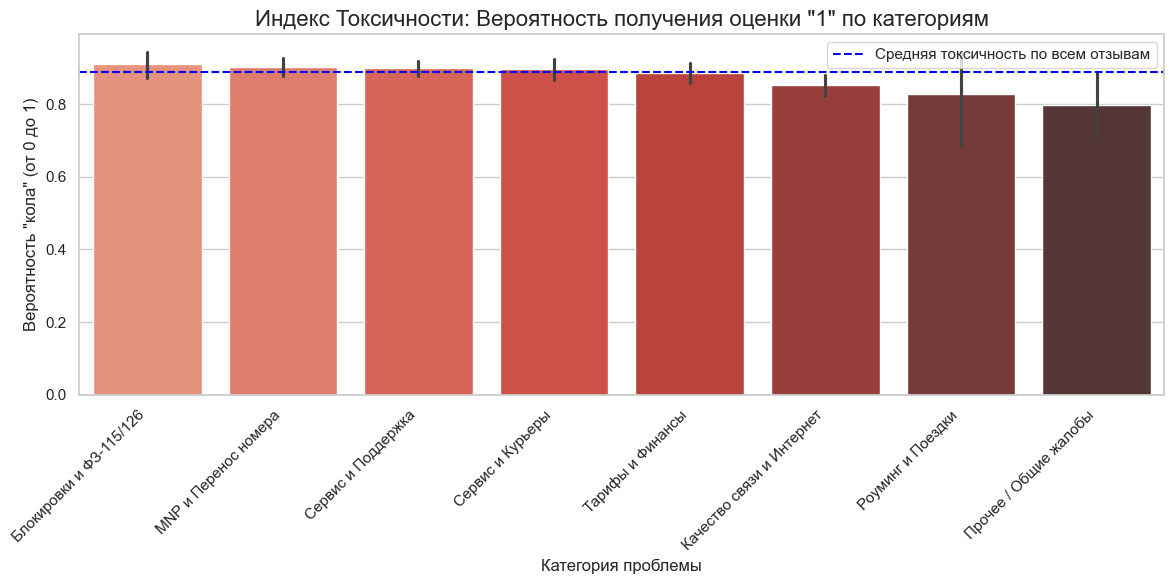

C:\Users\anton\AppData\Local\Temp\ipykernel_1800\140630641.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


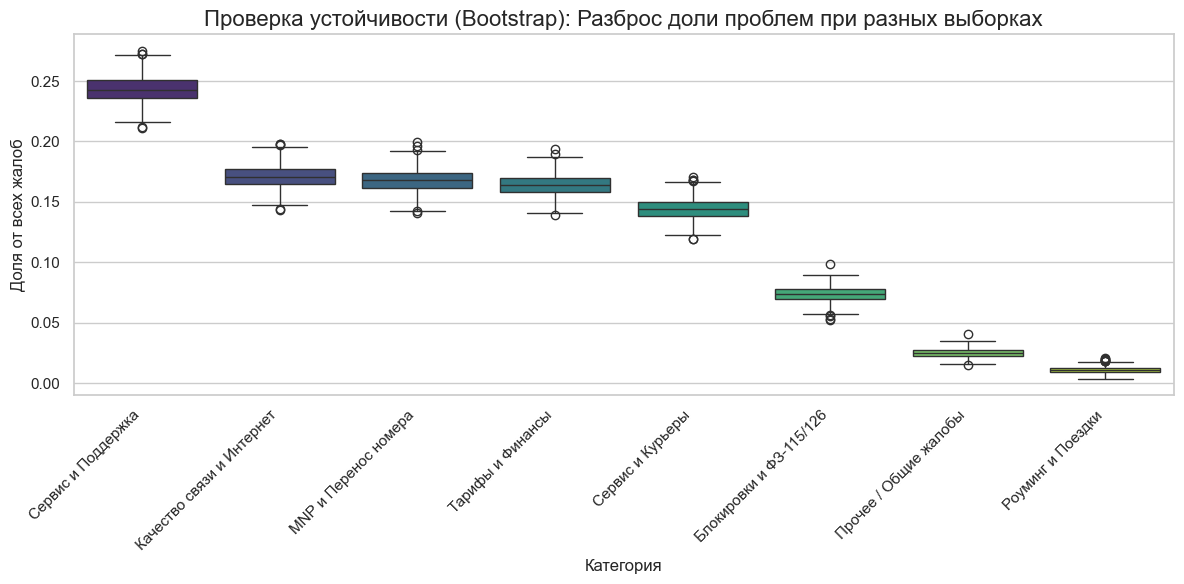

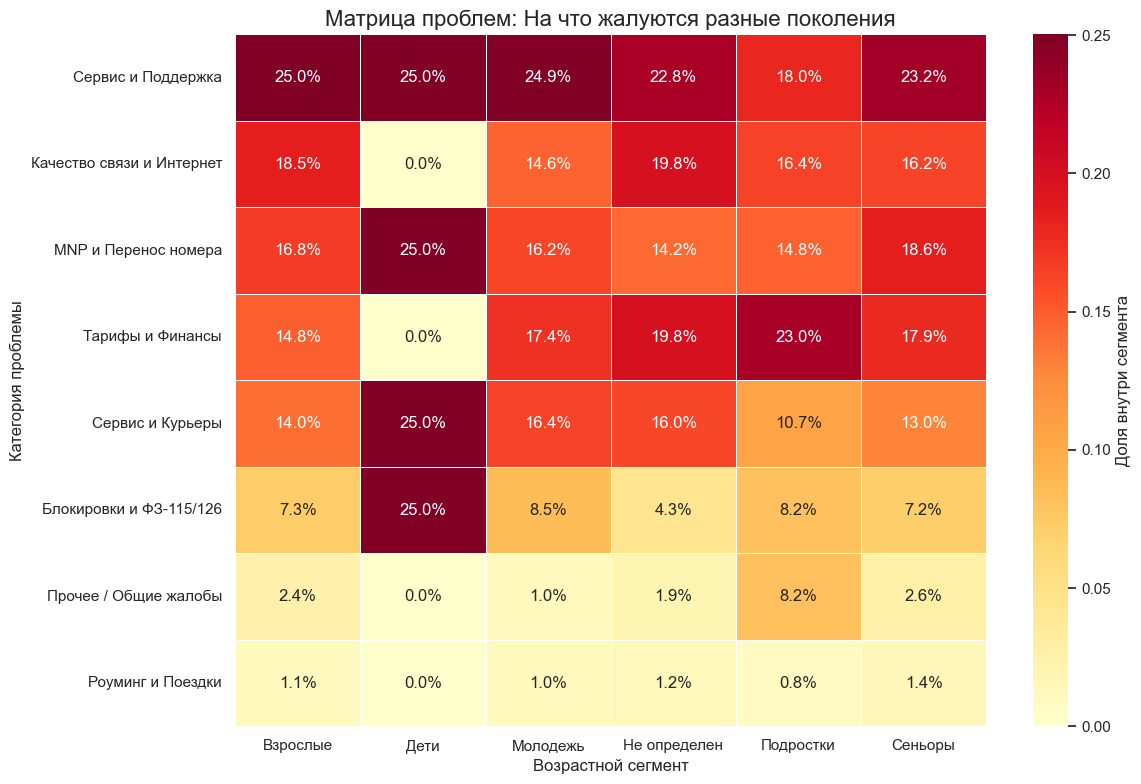

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample

# --- НАСТРОЙКИ ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# 1. Загрузка данных
file_path = 'negative_t_mobile_reviews_categorized.csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print("Файл не найден. Пожалуйста, загрузите файл.")
    exit()

# 2. Препроцессинг (Разбиваем категории)
def clean_categories(cat):
    if pd.isna(cat): return []
    # Удаляем лишние символы и разбиваем по запятой
    return [x.strip() for x in str(cat).replace('\n', '').replace('\r', '').split(',') if len(x.strip()) > 0]

df['cats_list'] = df['auto_category'].apply(clean_categories)
df_exploded = df.explode('cats_list')
df_exploded = df_exploded.dropna(subset=['cats_list'])

# Отфильтруем редкие категории (оставим топ-10 для чистоты графиков)
top_10_cats = df_exploded['cats_list'].value_counts().nlargest(10).index.tolist()
df_top = df_exploded[df_exploded['cats_list'].isin(top_10_cats)].copy()

# ==============================================================================
# ГРАФИК 1: АНАЛИЗ ТОКСИЧНОСТИ (ДЛЯ ХИ-КВАДРАТ)
# Гипотеза: Есть категории, которые "убивают" лояльность (дают 1 балл чаще других)
# ==============================================================================

# Создаем флаг "Фатальная оценка" (Оценка = 1)
df_top['is_fatal'] = df_top['review_mark'].apply(lambda x: 1 if x == 1 else 0)

plt.figure(figsize=(12, 6))
# Строим барплот, где высота столбца = среднее значение is_fatal (то есть % единиц)
# Черная черточка сверху - это доверительный интервал (CI 95%) от Seaborn
ax1 = sns.barplot(
    data=df_top,
    x='cats_list',
    y='is_fatal',
    palette='Reds_d',
    order=df_top.groupby('cats_list')['is_fatal'].mean().sort_values(ascending=False).index
)

plt.title('Индекс Токсичности: Вероятность получения оценки "1" по категориям', fontsize=16)
plt.ylabel('Вероятность "кола" (от 0 до 1)', fontsize=12)
plt.xlabel('Категория проблемы', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.axhline(y=df_top['is_fatal'].mean(), color='blue', linestyle='--', label='Средняя токсичность по всем отзывам')
plt.legend()
plt.tight_layout()
plt.show()


# ==============================================================================
# ГРАФИК 2: БУТСТРЕП АНАЛИЗ (BOXPLOT)
# Гипотеза: Топ проблем устойчив и не зависит от случайности выборки
# ==============================================================================

n_iterations = 500
bootstrap_data = []

# Запускаем симуляцию
for i in range(n_iterations):
    # Берем случайную подвыборку
    sample = resample(df_top, n_samples=int(len(df_top)*0.5), random_state=i) # 50% выборки
    # Считаем доли категорий в этой подвыборке
    counts = sample['cats_list'].value_counts(normalize=True)

    for cat in top_10_cats:
        bootstrap_data.append({
            'Категория': cat,
            'Доля обращений': counts.get(cat, 0)
        })

df_boot = pd.DataFrame(bootstrap_data)

plt.figure(figsize=(12, 6))
# Boxplot показывает разброс значений при 500 симуляциях
sns.boxplot(
    data=df_boot,
    x='Категория',
    y='Доля обращений',
    palette='viridis',
    order=df_boot.groupby('Категория')['Доля обращений'].median().sort_values(ascending=False).index
)

plt.title('Проверка устойчивости (Bootstrap): Разброс доли проблем при разных выборках', fontsize=16)
plt.ylabel('Доля от всех жалоб', fontsize=12)
plt.xlabel('Категория', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# ==============================================================================
# ГРАФИК 3: ТЕПЛОВАЯ КАРТА СЕГМЕНТОВ (HEATMAP)
# Гипотеза: Разные возраста жалуются на разное
# ==============================================================================

plt.figure(figsize=(12, 8))

# Строим кросс-таблицу: Категории vs Возрастные сегменты
# normalize='columns' означает, что сумма по столбцу (сегменту) будет 100%
pivot_table = pd.crosstab(
    df_top['cats_list'],
    df_top['age_segment'],
    normalize='columns'
)

# Сортируем для красоты
pivot_table = pivot_table.sort_values(by=pivot_table.columns[0], ascending=False)

sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".1%",
    cmap="YlOrRd",
    linewidths=.5,
    cbar_kws={'label': 'Доля внутри сегмента'}
)

plt.title('Матрица проблем: На что жалуются разные поколения', fontsize=16)
plt.ylabel('Категория проблемы', fontsize=12)
plt.xlabel('Возрастной сегмент', fontsize=12)
plt.tight_layout()
plt.show()

Сильные проблемы в общем, поэтому все жалуются на поддержку при любой проблеме, стоит дать больше свободы операторам, по типу выдавать бонусы.

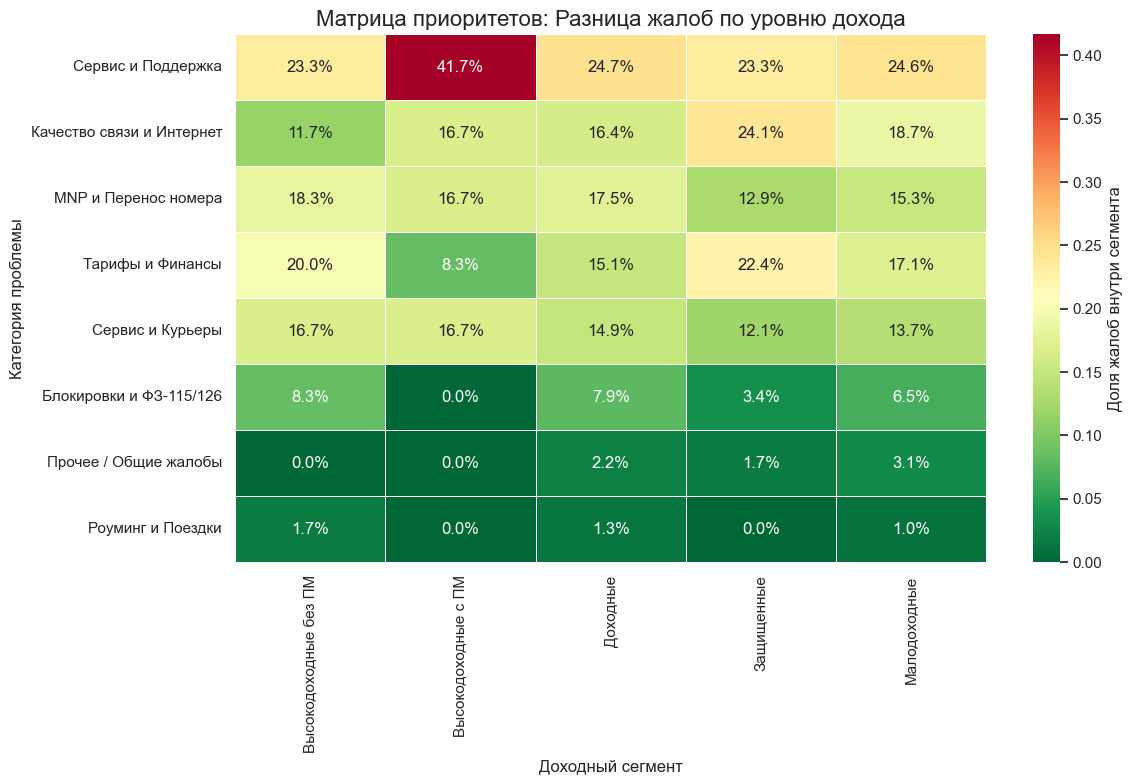

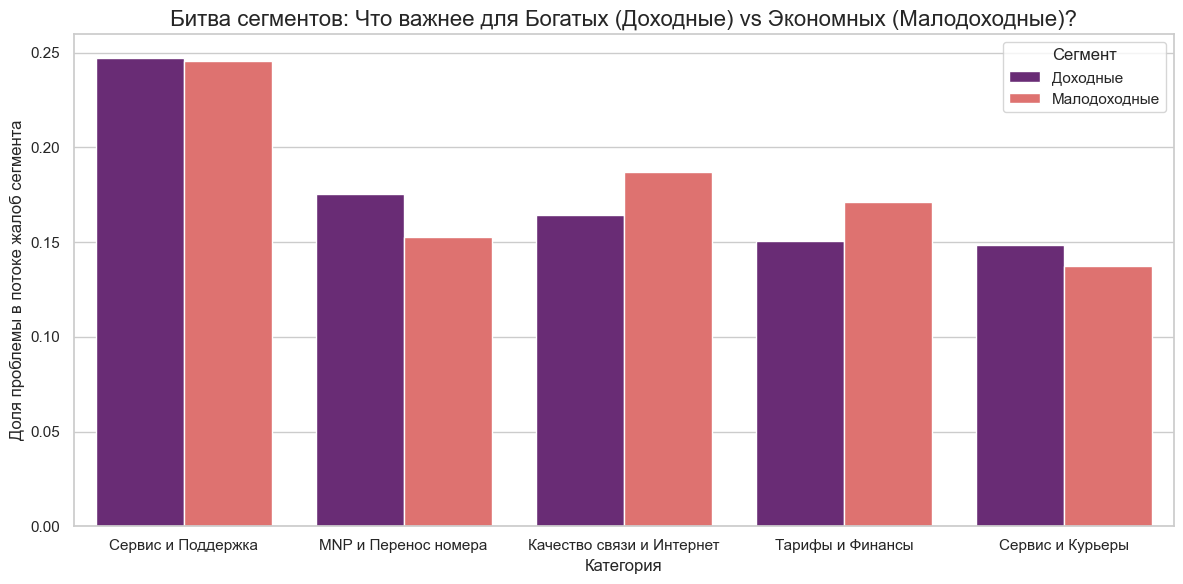

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Настройки стиля
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# 1. Загрузка данных
file_path = 'negative_t_mobile_reviews_categorized.csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. Очистка данных
# Удаляем пустые сегменты (если вдруг есть)
df = df.dropna(subset=['segment_name'])

# Функция очистки категорий
def clean_categories(cat):
    if pd.isna(cat): return []
    return [x.strip() for x in str(cat).replace('\n', '').replace('\r', '').split(',') if len(x.strip()) > 0]

df['cats_list'] = df['auto_category'].apply(clean_categories)
df_exploded = df.explode('cats_list')
df_exploded = df_exploded.dropna(subset=['cats_list'])

# Оставляем только топ-12 категорий для чистоты графиков
top_cats = df_exploded['cats_list'].value_counts().nlargest(12).index.tolist()
df_filtered = df_exploded[df_exploded['cats_list'].isin(top_cats)]

# ==============================================================================
# ГРАФИК 1: ТЕПЛОВАЯ КАРТА (HEATMAP)
# Вопрос: Что болит у "Доходных" vs "Малодоходных"?
# ==============================================================================

plt.figure(figsize=(12, 8))

# Строим таблицу сопряженности (Crosstab)
# normalize='columns' -> Сумма по каждому сегменту = 100%
pivot_income = pd.crosstab(
    df_filtered['cats_list'],
    df_filtered['segment_name'],
    normalize='columns'
)

# Сортируем категории по общей популярности
pivot_income = pivot_income.loc[top_cats]

sns.heatmap(
    pivot_income,
    annot=True,
    fmt=".1%",
    cmap="RdYlGn_r", # От зеленого (мало жалоб) к красному (много)
    linewidths=.5,
    cbar_kws={'label': 'Доля жалоб внутри сегмента'}
)

plt.title('Матрица приоритетов: Разница жалоб по уровню дохода', fontsize=16)
plt.ylabel('Категория проблемы', fontsize=12)
plt.xlabel('Доходный сегмент', fontsize=12)
plt.tight_layout()
plt.show()

# ==============================================================================
# ГРАФИК 2: ГЛУБОКИЙ АНАЛИЗ ТОП-5 ПРОБЛЕМ
# Вопрос: Есть ли разрыв восприятия в ключевых проблемах?
# ==============================================================================

top_5_cats = top_cats[:5]
df_top5 = df_filtered[df_filtered['cats_list'].isin(top_5_cats)]

# Считаем доли внутри групп
grouped_data = df_top5.groupby(['cats_list', 'segment_name']).size().reset_index(name='count')
# Нормируем: переводим абсолютные числа в проценты внутри категории, чтобы сравнить вклад сегментов
# (Или лучше показать долю проблемы внутри сегмента, как на хитмапе, но в виде баров для наглядности сравнения)

# Вариант: Сравнение распределения проблем для двух полярных групп (если они есть)
target_segments = ['Доходные', 'Малодоходные'] # Проверьте, есть ли точно такие названия в CSV
if all(seg in df['segment_name'].unique() for seg in target_segments):
    df_target = df_filtered[df_filtered['segment_name'].isin(target_segments)]

    # Считаем % проблем внутри каждого сегмента
    counts = (df_target.groupby(['segment_name'])['cats_list']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .reset_index())

    # Оставляем только топ-5 проблем для графика
    counts = counts[counts['cats_list'].isin(top_5_cats)]

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=counts,
        x='cats_list',
        y='percentage',
        hue='segment_name',
        palette='magma'
    )

    plt.title('Битва сегментов: Что важнее для Богатых (Доходные) vs Экономных (Малодоходные)?', fontsize=16)
    plt.ylabel('Доля проблемы в потоке жалоб сегмента', fontsize=12)
    plt.xlabel('Категория', fontsize=12)
    plt.legend(title='Сегмент')
    plt.tight_layout()
    plt.show()
else:
    print(f"Внимание: В данных нет сегментов {target_segments}. Доступные сегменты:", df['segment_name'].unique())
    # Если конкретных нет, строим просто общий барплот по всем сегментам
    plt.figure(figsize=(14, 6))
    sns.countplot(data=df_filtered, x='cats_list', hue='segment_name', palette='viridis')
    plt.xticks(rotation=45)
    plt.title('Абсолютное количество жалоб по сегментам', fontsize=16)
    plt.show()

Файл загружен.
Всего отзывов: 56820
Отзывов про Т-Мобайл: 1247


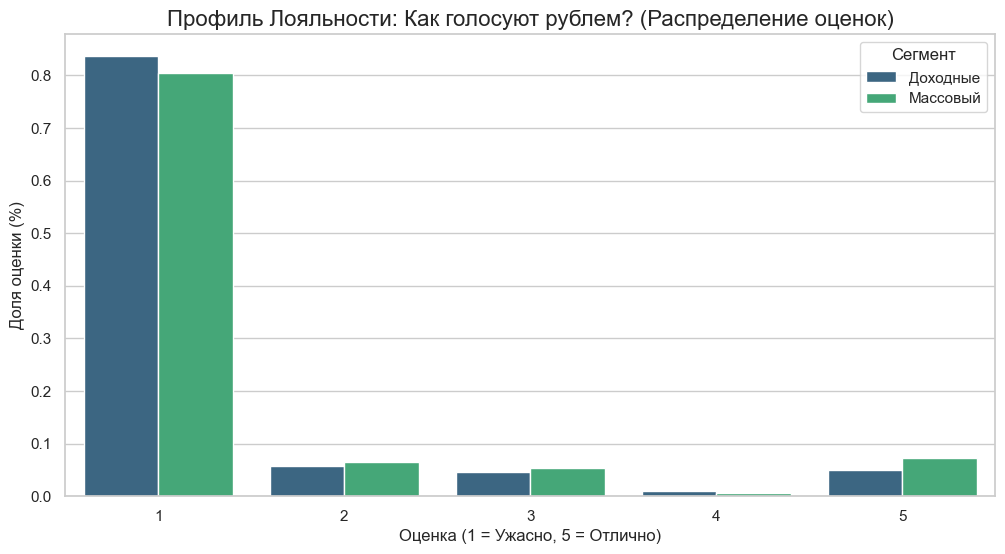

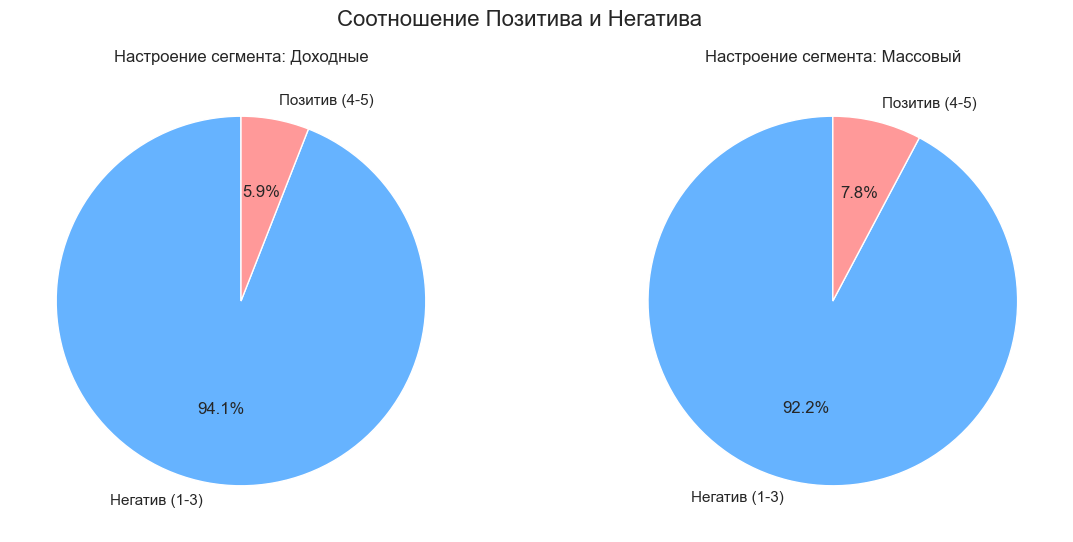

C:\Users\anton\AppData\Local\Temp\ipykernel_1800\247613053.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pos_counts.values, y=pos_counts.index, palette='Greens_r')
C:\Dano_coding\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


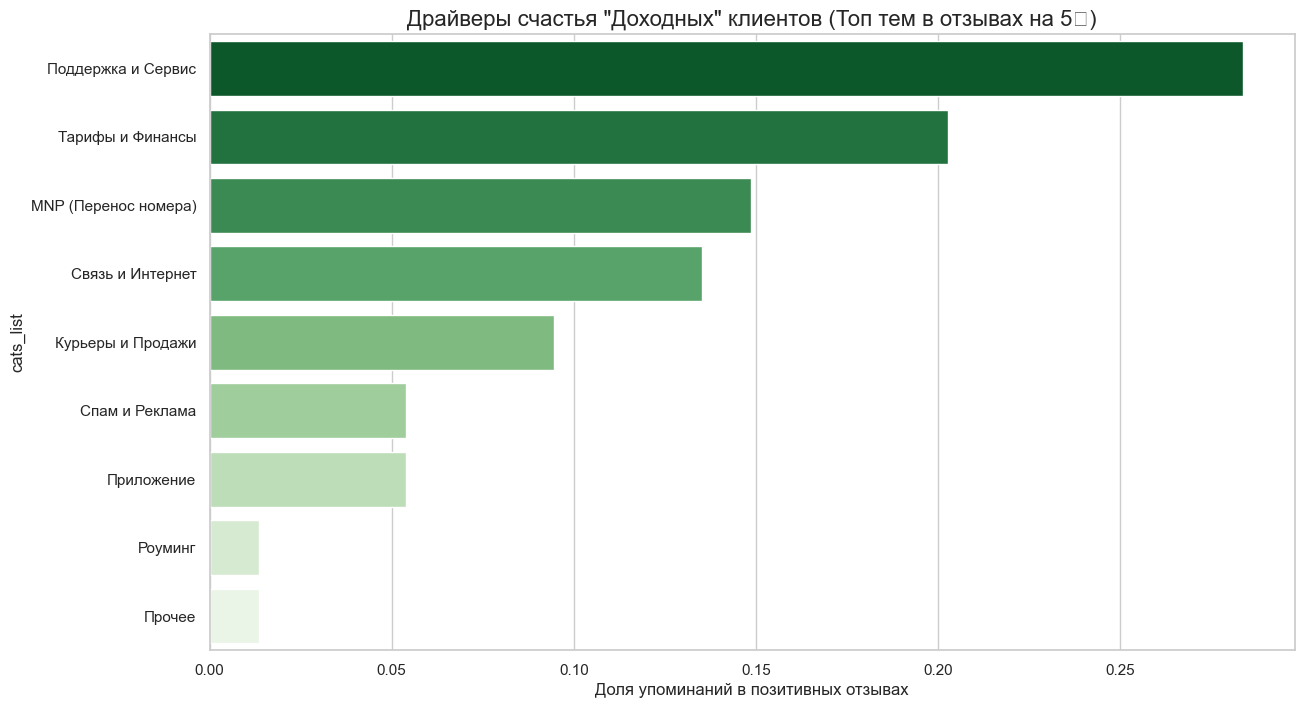


--- ИТОГОВАЯ СТАТИСТИКА ---
Средняя оценка 'Доходные': 1.38
Средняя оценка 'Массовый': 1.48
ВЫВОД: Разницы в восприятии нет. Продукт оценивают одинаково.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Настройки стиля
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# 1. Загрузка данных
file_path = 'cleaned.csv'
try:
    df = pd.read_csv(file_path)
    print("Файл загружен.")
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. Фильтрация данных
# Нам нужны только отзывы про Мобайл
df_mobile = df[df['company'] == 'Мобайл'].copy()

print(f"Всего отзывов: {len(df)}")
print(f"Отзывов про Т-Мобайл: {len(df_mobile)}")

# 3. Авто-категоризация (Ключевые слова)
# Воссоздаем логику классификации, чтобы понять темы
keywords = {
    'Связь и Интернет': ['связ', 'интернет', 'сеть', 'ловит', 'lte', '4g', '3g', 'скорость', 'вышка', 'палочк'],
    'Тарифы и Финансы': ['тариф', 'цен', 'плат', 'списал', 'деньг', 'руб', 'дорог', 'подписк', 'услуг'],
    'Поддержка и Сервис': ['поддержк', 'чат', 'оператор', 'бот', 'отвечает', 'хам', 'ждал', 'дозвон'],
    'MNP (Перенос номера)': ['перенос', 'mnp', 'номер', 'переш', 'заявк', 'отказ'],
    'Курьеры и Продажи': ['курьер', 'представител', 'доставк', 'встреч', 'навязал', 'симк'],
    'Роуминг': ['роуминг', 'границ', 'поездк', 'зарубеж'],
    'Спам и Реклама': ['спам', 'звонк', 'реклам', 'смс'],
    'Приложение': ['приложен', 'app', 'глючит', 'вылетает', 'вход', 'баг']
}

def classify_text(text):
    text = str(text).lower()
    found_cats = []
    for cat, words in keywords.items():
        if any(w in text for w in words):
            found_cats.append(cat)
    return found_cats if found_cats else ['Прочее']

# Применяем классификацию
df_mobile['cats_list'] = df_mobile['review_text'].apply(classify_text)
df_exploded = df_mobile.explode('cats_list')

# 4. Анализ Сегментов
# Выделяем "Доходные" и всех остальных (Массовый сегмент)
target_segment = 'Доходные'
# Проверяем, есть ли такой сегмент, если нет - берем топ-2 популярных
if target_segment not in df_mobile['segment_name'].unique():
    print(f"Сегмент '{target_segment}' не найден. Используем доступные.")
    top_segments = df_mobile['segment_name'].value_counts().nlargest(2).index.tolist()
    seg1, seg2 = top_segments[0], top_segments[1]
else:
    seg1 = target_segment
    # Все остальные объединяем в "Массовый" для сравнения
    df_mobile['segment_group'] = df_mobile['segment_name'].apply(lambda x: 'Доходные' if x == 'Доходные' else 'Массовый')
    seg1 = 'Доходные'
    seg2 = 'Массовый'
    # Обновляем exploded датафрейм тоже
    df_exploded['segment_group'] = df_exploded['segment_name'].apply(lambda x: 'Доходные' if x == 'Доходные' else 'Массовый')

# ==============================================================================
# ГРАФИК 1: Распределение Оценок (NPS proxy)
# Ставят ли богатые пятерки?
# ==============================================================================
plt.figure(figsize=(12, 6))

# Считаем % каждой оценки внутри группы
rating_dist = (df_mobile.groupby(['segment_group'])['review_mark']
               .value_counts(normalize=True)
               .rename('percentage')
               .reset_index())

sns.barplot(
    data=rating_dist,
    x='review_mark',
    y='percentage',
    hue='segment_group',
    palette='viridis'
)

plt.title('Профиль Лояльности: Как голосуют рублем? (Распределение оценок)', fontsize=16)
plt.ylabel('Доля оценки (%)', fontsize=12)
plt.xlabel('Оценка (1 = Ужасно, 5 = Отлично)', fontsize=12)
plt.legend(title='Сегмент')
plt.show()

# ==============================================================================
# ГРАФИК 2: Доля Негатива (Pie Charts)
# Сравниваем % плохих отзывов (1-3) vs Хороших (4-5)
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, segment in enumerate([seg1, seg2]):
    subset = df_mobile[df_mobile['segment_group'] == segment]
    # Негатив: 1-3, Позитив: 4-5
    sentiment = subset['review_mark'].apply(lambda x: 'Позитив (4-5)' if x >= 4 else 'Негатив (1-3)').value_counts()

    axes[i].pie(sentiment, labels=sentiment.index, autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'], startangle=90)
    axes[i].set_title(f'Настроение сегмента: {segment}')

plt.suptitle('Соотношение Позитива и Негатива', fontsize=16)
plt.show()

# ==============================================================================
# ГРАФИК 3: О чем говорят ПОЗИТИВНЫЕ отзывы?
# Что радует богатых?
# ==============================================================================
positive_reviews = df_exploded[df_exploded['review_mark'] >= 5]
if not positive_reviews.empty:
    plt.figure(figsize=(14, 8))

    # Считаем топ тем в позитиве для Доходных
    pos_counts = (positive_reviews[positive_reviews['segment_group'] == 'Доходные']['cats_list']
                  .value_counts(normalize=True)
                  .head(10))

    sns.barplot(x=pos_counts.values, y=pos_counts.index, palette='Greens_r')
    plt.title('Драйверы счастья "Доходных" клиентов (Топ тем в отзывах на 5★)', fontsize=16)
    plt.xlabel('Доля упоминаний в позитивных отзывах', fontsize=12)
    plt.show()

# ==============================================================================
# ВЫВОД СТАТИСТИКИ
# ==============================================================================
avg_mark_high = df_mobile[df_mobile['segment_group'] == 'Доходные']['review_mark'].mean()
avg_mark_mass = df_mobile[df_mobile['segment_group'] == 'Массовый']['review_mark'].mean()

print(f"\n--- ИТОГОВАЯ СТАТИСТИКА ---")
print(f"Средняя оценка 'Доходные': {avg_mark_high:.2f}")
print(f"Средняя оценка 'Массовый': {avg_mark_mass:.2f}")

diff = avg_mark_high - avg_mark_mass
if diff > 0.2:
    print("ВЫВОД: Доходные клиенты заметно лояльнее (+). Им нравится продукт.")
elif diff < -0.2:
    print("ВЫВОД: Доходные клиенты настроены критично (-). Продукт не соответствует их ожиданиям.")
else:
    print("ВЫВОД: Разницы в восприятии нет. Продукт оценивают одинаково.")

In [6]:
df["company"].unique()

array(['Банк', 'Страховая', 'SME', 'Инвест', 'Плашки Media', 'Мобайл',
       'ТРабота'], dtype=object)

Данные загружены.


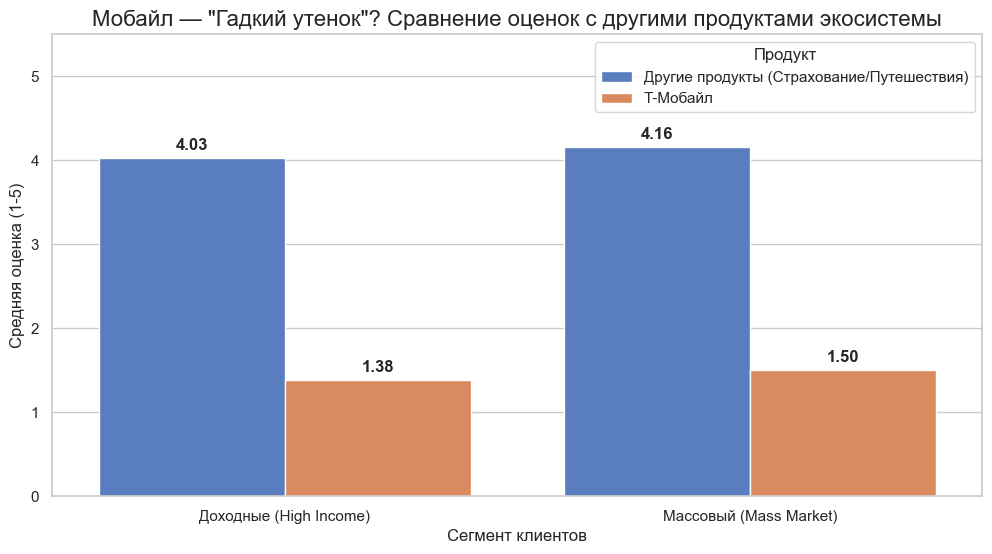

C:\Users\anton\AppData\Local\Temp\ipykernel_1800\1423770007.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  gap_plot = sns.barplot(x=pivot_avg['Gap'], y=pivot_avg.index, palette=colors)


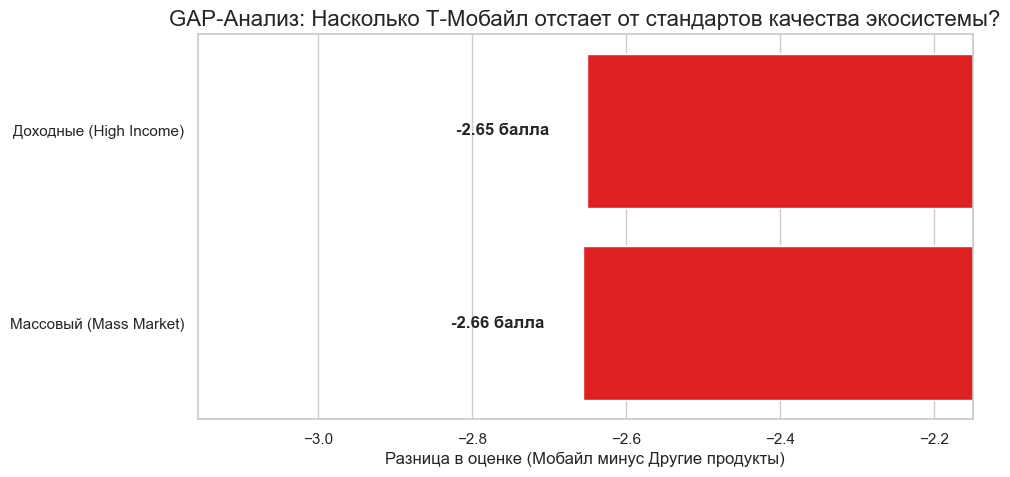


--- РЕЗУЛЬТАТЫ ПРОВЕРКИ ГИПОТЕЗЫ ---
Разрыв для Доходных: -2.65
Разрыв для Массовых: -2.66

🔴 КРИТИЧЕСКАЯ ПРОБЛЕМА:
Т-Мобайл сильно тянет рейтинг экосистемы вниз именно для Доходных клиентов.
Они привыкли к идеальному сервису, и Мобайл их разочаровывает.


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Настройки стиля
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Загрузка
try:
    df = pd.read_csv('cleaned.csv')
    print("Данные загружены.")
except FileNotFoundError:
    print("Файл cleaned.csv не найден.")
    exit()

# 2. Подготовка данных
# Нам нужно сравнить "Мобайл" с "Небанковскими продуктами"
# Исключаем 'Банк', чтобы сравнить именно экосистемные сервисы (Мобайл, Страхование, Путешествия и т.д.)
# Если вы хотите включить Банк в сравнение, закомментируйте следующую строку.
df_ecosystem = df[df['company'] != 'Банк'].copy()
df["company"].unique()
# Создаем флаг продукта
df_ecosystem['product_type'] = df_ecosystem['company'].apply(
    lambda x: 'Т-Мобайл' if x == 'Мобайл' else 'Другие продукты (Страхование/Путешествия)'
)

# Упрощаем сегменты до "Доходные" и "Массовые"
def simplify_segment(seg):
    if pd.isna(seg): return 'Неизвестно'
    if seg == 'Доходные': return 'Доходные (High Income)'
    return 'Массовый (Mass Market)'

df_ecosystem['segment_group'] = df_ecosystem['segment_name'].apply(simplify_segment)
df_ecosystem = df_ecosystem[df_ecosystem['segment_group'] != 'Неизвестно']

# ==============================================================================
# ГРАФИК 1: СРАВНЕНИЕ СРЕДНИХ ОЦЕНОК
# Гипотеза: Столбцы Мобайла будут ниже, чем столбцы Других продуктов
# ==============================================================================
plt.figure(figsize=(12, 6))

# Считаем средние оценки
avg_ratings = df_ecosystem.groupby(['segment_group', 'product_type'])['review_mark'].mean().reset_index()

barplot = sns.barplot(
    data=avg_ratings,
    x='segment_group',
    y='review_mark',
    hue='product_type',
    palette='muted'
)

plt.title('Мобайл — "Гадкий утенок"? Сравнение оценок с другими продуктами экосистемы', fontsize=16)
plt.ylabel('Средняя оценка (1-5)', fontsize=12)
plt.xlabel('Сегмент клиентов', fontsize=12)
plt.ylim(0, 5.5)
plt.legend(title='Продукт')

# Добавляем цифры
for p in barplot.patches:
    if p.get_height() > 0:
        barplot.annotate(f'{p.get_height():.2f}',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha = 'center', va = 'center',
                         xytext = (0, 9),
                         textcoords = 'offset points',
                         fontweight='bold')
plt.show()

# ==============================================================================
# ГРАФИК 2: GAP ANALYSIS (АНАЛИЗ РАЗРЫВА)
# Насколько Мобайл хуже/лучше других продуктов для каждого сегмента?
# ==============================================================================

# Пивот таблица для расчета разницы
pivot_avg = avg_ratings.pivot(index='segment_group', columns='product_type', values='review_mark')
pivot_avg['Gap'] = pivot_avg['Т-Мобайл'] - pivot_avg['Другие продукты (Страхование/Путешествия)']

plt.figure(figsize=(10, 5))
colors = ['red' if x < 0 else 'green' for x in pivot_avg['Gap']]
gap_plot = sns.barplot(x=pivot_avg['Gap'], y=pivot_avg.index, palette=colors)

plt.axvline(0, color='black', linewidth=1)
plt.title('GAP-Анализ: Насколько Т-Мобайл отстает от стандартов качества экосистемы?', fontsize=16)
plt.xlabel('Разница в оценке (Мобайл минус Другие продукты)', fontsize=12)
plt.ylabel('')

# Подписи значений
for i, v in enumerate(pivot_avg['Gap']):
    offset = 0.05 if v >= 0 else -0.05
    ha = 'left' if v >= 0 else 'right'
    gap_plot.text(v + offset, i, f"{v:.2f} балла", va='center', ha=ha, fontweight='bold', fontsize=12)

plt.xlim(min(pivot_avg['Gap']) - 0.5, max(pivot_avg['Gap']) + 0.5)
plt.show()

# ==============================================================================
# ВЫВОДЫ В КОНСОЛЬ
# ==============================================================================
print("\n--- РЕЗУЛЬТАТЫ ПРОВЕРКИ ГИПОТЕЗЫ ---")
gap_high = pivot_avg.loc['Доходные (High Income)', 'Gap']
gap_mass = pivot_avg.loc['Массовый (Mass Market)', 'Gap']

print(f"Разрыв для Доходных: {gap_high:.2f}")
print(f"Разрыв для Массовых: {gap_mass:.2f}")

if gap_high < -0.5:
    print("\n🔴 КРИТИЧЕСКАЯ ПРОБЛЕМА:")
    print("Т-Мобайл сильно тянет рейтинг экосистемы вниз именно для Доходных клиентов.")
    print("Они привыкли к идеальному сервису, и Мобайл их разочаровывает.")
elif gap_high < 0:
    print("\n🟠 УМЕРЕННАЯ ПРОБЛЕМА:")
    print("Т-Мобайл оценивают чуть хуже других продуктов, но разрыв не катастрофический.")
else:
    print("\n🟢 ГИПОТЕЗА ОПРОВЕРГНУТА:")
    print("Т-Мобайл оценивают ТАК ЖЕ или ЛУЧШЕ, чем другие продукты экосистемы.")

Данные загружены.
Размер выборки для анализа: 22464 строк

 ЭТАП 1: ОСНОВНОЙ РАСЧЕТ (OLS + LOGIT)
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     482.0
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        23:02:38   Log-Likelihood:                -39087.
No. Observations:               22464   AIC:                         7.820e+04
Df Residuals:                   22450   BIC:                         7.831e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----

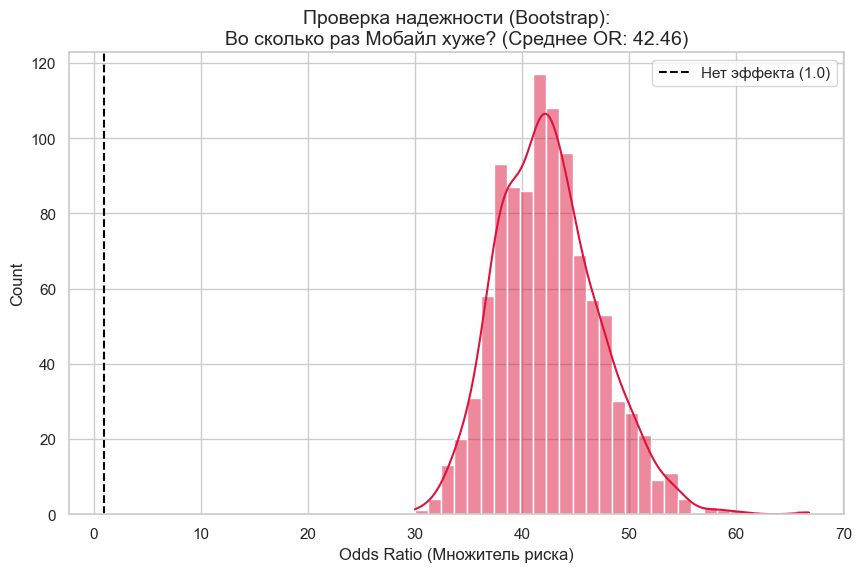

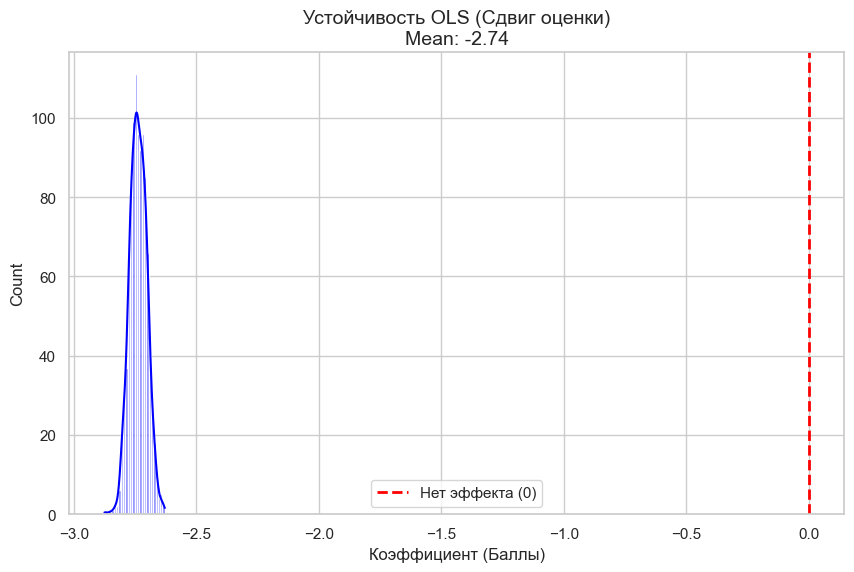


 ФИНАЛЬНЫЙ ВЕРДИКТ ИССЛЕДОВАНИЯ
1.OLS (Снижение оценки):
95% Интервал: от -2.80 до -2.67
Вывод: ✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА. Оценка падает всегда.

2. LOGIT (Рост риска):
95% Интервал: от 34.28 до 52.60
Вывод: ✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА. Риск растет всегда.


In [26]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

def print_header(title):
    print("\n" + "="*80)
    print(f" {title}")
    print("="*80)

try:
    df = pd.read_csv('cleaned.csv')
    print("Данные загружены.")
except FileNotFoundError:
    print("Файл не найден. Пожалуйста, загрузите cleaned.csv")
    exit()
df_model = df[df['company'] != 'Банк'].copy()

df_model = df_model.dropna(subset=['review_mark'])
df_model['score'] = df_model['review_mark'].astype(float)

df_model['is_negative'] = df_model['review_mark'].apply(lambda x: 1 if x <= 3 else 0)
df_model['is_mobile'] = df_model['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

df_model['segment_name'] = df_model['segment_name'].fillna('Массовый')
df_model['age_segment'] = df_model['age_segment'].fillna('Взрослые')
df_model['gender_cd'] = df_model['gender_cd'].fillna('U')
cols_to_encode = ['segment_name', 'age_segment', 'gender_cd']
X_encoded = pd.get_dummies(df_model[cols_to_encode], drop_first=True)

# Собираем финальную матрицу X
X = pd.concat([df_model[['is_mobile']], X_encoded], axis=1)
y = df_model['is_negative']

print(f"Размер выборки для анализа: {len(df_model)} строк")

print_header("ЭТАП 1: ОСНОВНОЙ РАСЧЕТ (OLS + LOGIT)")

formula_ols = "score ~ is_mobile + C(segment_name) + C(age_segment) + C(gender_cd)"
formula_logit = "is_negative ~ is_mobile + C(segment_name) + C(age_segment) + C(gender_cd)"
model_ols = smf.ols(formula_ols, data=df_model).fit()
beta_mobile = model_ols.params['is_mobile']
p_ols = model_ols.pvalues['is_mobile']
print(model_ols.summary())
model_logit = smf.logit(formula_logit, data=df_model).fit(disp=0)
log_odds_mobile = model_logit.params['is_mobile']
odds_ratio_mobile = np.exp(log_odds_mobile)
p_logit = model_logit.pvalues['is_mobile']
print(model_logit.summary())
results_df = pd.DataFrame({
    'Модель': ['OLS (Влияние на балл)', 'LOGIT (Влияние на риск)'],
    'Ключевая Метрика': ['Коэффициент (Beta)', 'Odds Ratio (Шансы)'],
    'Значение': [f"{beta_mobile:.3f}", f"{odds_ratio_mobile:.3f}"],
    'P-value': [f"{p_ols:.5f}", f"{p_logit:.5f}"],
    'Вердикт (p<0.05)': ['✅ ЗНАЧИМО' if p_ols < 0.05 else '❌ НЕТ', '✅ ЗНАЧИМО' if p_logit < 0.05 else '❌ НЕТ']
})

print(results_df)

print("\nИНТЕРПРЕТАЦИЯ:")
if beta_mobile < 0:
    print(f"1. OLS: Т-Мобайл снижает среднюю оценку на {abs(beta_mobile):.2f} балла.")
if odds_ratio_mobile > 1:
    print(f"2. LOGIT: Т-Мобайл повышает вероятность негатива в {odds_ratio_mobile:.2f} РАЗА.")

# ==============================================================================
# ЧАСТЬ 2: BOOTSTRAP (ПРОВЕРКА УСТОЙЧИВОСТИ)
# Запускаем 500 симуляций для ОБЕИХ моделей
# ==============================================================================
clf = LogisticRegression(penalty='l2', C=1.0, max_iter=2000, solver='lbfgs')
print_header("ЭТАП 2: СТРЕСС-ТЕСТ (BOOTSTRAP - 1000 ИТЕРАЦИЙ)")
print("Ждите, идет расчет симуляций...")
n_iterations = 1000
boot_ols = []
boot_mobile = []
for i in range(n_iterations):
    sample = resample(df_model, replace=True, n_samples=len(df_model), random_state=i)
    res_ols = smf.ols(formula_ols, data=sample).fit()
    boot_ols.append(res_ols.params['is_mobile'])
    X_sample, y_sample = resample(X, y, random_state=i)
    clf.fit(X_sample, y_sample)
    boot_mobile.append(np.exp(clf.coef_[0][0]))

plt.figure(figsize=(10, 6))
sns.histplot(boot_mobile, kde=True, color='crimson')
plt.axvline(1, color='black', linestyle='--', label='Нет эффекта (1.0)')
plt.title(f'Проверка надежности (Bootstrap):\nВо сколько раз Мобайл хуже? (Среднее OR: {np.mean(boot_mobile):.2f})', fontsize=14)
plt.xlabel('Odds Ratio (Множитель риска)', fontsize=12)
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(boot_ols, kde=True, color='blue')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Нет эффекта (0)')
plt.title(f'Устойчивость OLS (Сдвиг оценки)\nMean: {np.mean(boot_ols):.2f}', fontsize=14)
plt.xlabel('Коэффициент (Баллы)', fontsize=12)
plt.legend()
plt.show()


# ==============================================================================
# ФИНАЛЬНЫЙ ОТЧЕТ
# ==============================================================================
print_header("ФИНАЛЬНЫЙ ВЕРДИКТ ИССЛЕДОВАНИЯ")

ols_conf = np.percentile(boot_ols, [2.5, 97.5])
logit_conf = np.percentile(boot_mobile, [2.5, 97.5])

print(f"1.OLS (Снижение оценки):")
print(f"95% Интервал: от {ols_conf[0]:.2f} до {ols_conf[1]:.2f}")
if ols_conf[1] < 0:
    print("Вывод: ✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА. Оценка падает всегда.")
else:
    print("Вывод: ⚠️ РЕЗУЛЬТАТ НЕУСТОЙЧИВ.")

print(f"\n2. LOGIT (Рост риска):")
print(f"95% Интервал: от {logit_conf[0]:.2f} до {logit_conf[1]:.2f}")
if logit_conf[0] > 1:
    print("Вывод: ✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА. Риск растет всегда.")
else:
    print("Вывод: ⚠️ РЕЗУЛЬТАТ НЕУСТОЙЧИВ.")


Advanced

Обучаем Random Forest...


C:\Users\anton\AppData\Local\Temp\ipykernel_5248\1928761803.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df, x='Importance', y='Feature', palette=colors)


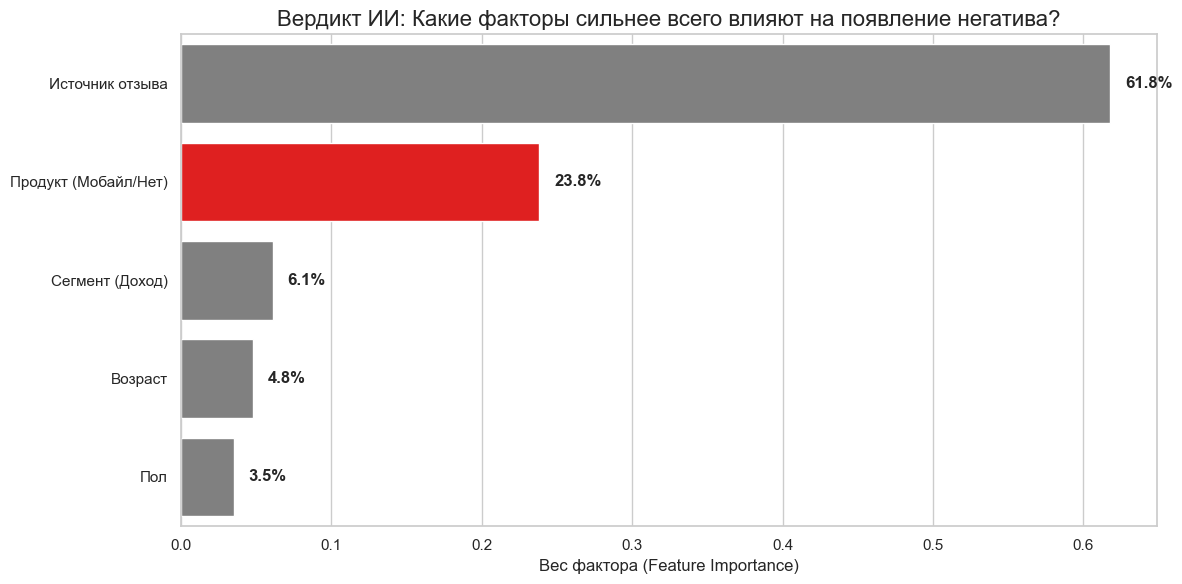


 РЕЗУЛЬТАТЫ ML-МОДЕЛИ (RANDOM FOREST) 
Самый важный фактор по мнению ИИ: Источник отзыва
Его влияние (вес): 61.8%

⚠️ ГИПОТЕЗА ПОД ВОПРОСОМ.
Для алгоритма важнее другие факторы (например, источник отзыва).


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Настройки
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. ЗАГРУЗКА
try:
    df = pd.read_csv('cleaned.csv')
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. ПОДГОТОВКА ДАННЫХ
# Убираем Банк, сравниваем Мобайл vs Экосистема
df_model = df[df['company'] != 'Банк'].copy()
df_model = df_model.dropna(subset=['review_mark'])

# Целевая переменная: Негатив (1) или Позитив (0)
y = df_model['review_mark'].apply(lambda x: 1 if x <= 3 else 0)

# Признаки (X)
# Создаем DataFrame только с нужными колонками
X = pd.DataFrame()
X['is_mobile'] = df_model['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

# Кодируем категориальные признаки (Пол, Возраст, Доход)
le = LabelEncoder()

# Заполняем пропуски и кодируем в числа
X['segment_code'] = le.fit_transform(df_model['segment_name'].fillna('Unknown'))
X['age_code'] = le.fit_transform(df_model['age_segment'].fillna('Unknown'))
X['gender_code'] = le.fit_transform(df_model['gender_cd'].fillna('Unknown'))

# Добавим источник отзыва (вдруг Banki.ru важнее?)
top_sources = df_model['review_source'].value_counts().nlargest(5).index
X['source_code'] = le.fit_transform(df_model['review_source'].apply(lambda x: x if x in top_sources else 'Other'))

# 3. ОБУЧЕНИЕ RANDOM FOREST
# Мы используем лес из 100 деревьев
print("Обучаем Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5, class_weight='balanced')
rf.fit(X, y)

# 4. ИЗВЛЕЧЕНИЕ ВАЖНОСТИ (FEATURE IMPORTANCE)
importances = rf.feature_importances_
feature_names = ['Продукт (Мобайл/Нет)', 'Сегмент (Доход)', 'Возраст', 'Пол', 'Источник отзыва']

# Создаем DataFrame для графика
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values('Importance', ascending=False)

# 5. ВИЗУАЛИЗАЦИЯ
plt.figure(figsize=(12, 6))
# Используем цветовую схему: Выделим Мобайл красным
colors = ['red' if 'Продукт' in x else 'gray' for x in fi_df['Feature']]

sns.barplot(data=fi_df, x='Importance', y='Feature', palette=colors)

plt.title('Вердикт ИИ: Какие факторы сильнее всего влияют на появление негатива?', fontsize=16)
plt.xlabel('Вес фактора (Feature Importance)', fontsize=12)
plt.ylabel('')

# Добавляем подписи
for i, v in enumerate(fi_df['Importance']):
    plt.text(v + 0.01, i, f"{v:.1%}", va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 6. ТЕКСТОВЫЙ ВЫВОД
print("\n" + "="*60)
print(" РЕЗУЛЬТАТЫ ML-МОДЕЛИ (RANDOM FOREST) ")
print("="*60)
top_feature = fi_df.iloc[0]['Feature']
top_score = fi_df.iloc[0]['Importance']

print(f"Самый важный фактор по мнению ИИ: {top_feature}")
print(f"Его влияние (вес): {top_score:.1%}")

if 'Продукт' in top_feature:
    print("\n✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА (ML METHOD).")
    print("Алгоритм считает, что тип продукта важнее, чем личность клиента (пол/возраст).")
    print("Это самый сильный аргумент для презентации.")
else:
    print("\n⚠️ ГИПОТЕЗА ПОД ВОПРОСОМ.")
    print("Для алгоритма важнее другие факторы (например, источник отзыва).")


 ШАГ 1: ВИЗУАЛЬНОЕ СРАВНЕНИЕ (BOXPLOT)


C:\Users\anton\AppData\Local\Temp\ipykernel_5248\2617097396.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='company', y='review_mark', data=df_nonfin, order=order, palette='Set3')


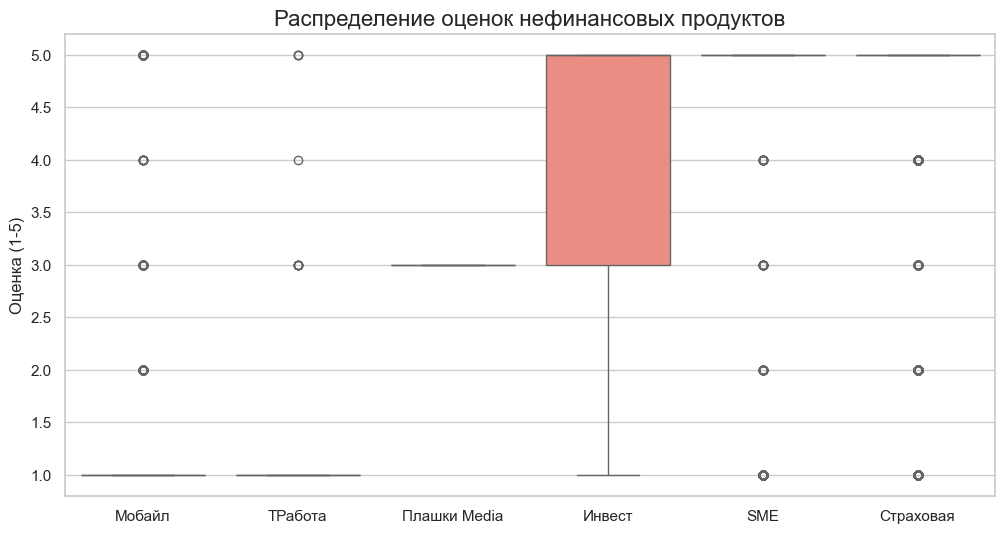


 ШАГ 2: СЕРИЯ ДУЭЛЕЙ (MANN-WHITNEY U TEST)
Гипотеза H1: Оценки 'Мобайл' СТАТИСТИЧЕСКИ НИЖЕ, чем у конкурента.

      Конкурент    Mobile Хуже?        P-value Вероятность проигрыша
0     Страховая  ✅ ДА (Значимо)   0.000000e+00                 90.7%
1           SME  ✅ ДА (Значимо)   0.000000e+00                 90.4%
2        Инвест  ✅ ДА (Значимо)   0.000000e+00                 82.8%
3  Плашки Media  ✅ ДА (Значимо)  2.088340e-223                 90.5%
4       ТРабота           ❌ НЕТ   1.345384e-01                 53.2%

 ИТОГОВЫЙ ВЕРДИКТ
⚠️ РЕЗУЛЬТАТ НЕОДНОЗНАЧНЫЙ.
Мобайл не хуже, чем: ['ТРабота']

[Глобальный тест Краскела-Уоллиса]
Есть ли вообще разница между продуктами? Да (p=0.00000)


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Настройки
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

def print_header(title):
    print("\n" + "="*80)
    print(f" {title}")
    print("="*80)

# 1. ЗАГРУЗКА
try:
    df = pd.read_csv('cleaned.csv')
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. ПОДГОТОВКА
# Исключаем Банк, чтобы сравнить сервисные продукты
df_nonfin = df[df['company'] != 'Банк'].copy()
df_nonfin = df_nonfin.dropna(subset=['review_mark'])

# Список продуктов для сравнения
products = df_nonfin['company'].unique()
target_product = 'Мобайл'

if target_product not in products:
    print(f"Ошибка: Продукт '{target_product}' не найден в данных.")
    exit()

# ==============================================================================
# ВИЗУАЛИЗАЦИЯ (BOXPLOT) - ЧТОБЫ УВИДЕТЬ ГЛАЗАМИ
# ==============================================================================
print_header("ШАГ 1: ВИЗУАЛЬНОЕ СРАВНЕНИЕ (BOXPLOT)")

# Сортируем продукты по медианной оценке (от худшего к лучшему)
order = df_nonfin.groupby('company')['review_mark'].median().sort_values().index

plt.figure(figsize=(12, 6))
sns.boxplot(x='company', y='review_mark', data=df_nonfin, order=order, palette='Set3')
plt.title('Распределение оценок нефинансовых продуктов', fontsize=16)
plt.ylabel('Оценка (1-5)', fontsize=12)
plt.xlabel('')
plt.show()

# ==============================================================================
# СТАТИСТИЧЕСКИЙ ТЕСТ (MANN-WHITNEY U)
# ==============================================================================
print_header("ШАГ 2: СЕРИЯ ДУЭЛЕЙ (MANN-WHITNEY U TEST)")
print(f"Гипотеза H1: Оценки '{target_product}' СТАТИСТИЧЕСКИ НИЖЕ, чем у конкурента.\n")

results = []
mobile_ratings = df_nonfin[df_nonfin['company'] == target_product]['review_mark']

for competitor in products:
    if competitor == target_product:
        continue

    comp_ratings = df_nonfin[df_nonfin['company'] == competitor]['review_mark']

    # Тест Манна-Уитни
    # alternative='less' означает: Проверяем, что медиана Mobile МЕНЬШЕ медианы Competitor
    stat, p_value = stats.mannwhitneyu(mobile_ratings, comp_ratings, alternative='less')

    # Размер эффекта (Common Language Effect Size)
    # Вероятность того, что случайная оценка Мобайла будет ниже случайной оценки Конкурента
    n1 = len(mobile_ratings)
    n2 = len(comp_ratings)
    u1 = stat
    cles = u1 / (n1 * n2) # Вероятность, что Mobile > Competitor
    prob_worse = 1 - cles # Вероятность, что Mobile < Competitor

    results.append({
        'Конкурент': competitor,
        'Средняя оценка (Их)': comp_ratings.mean(),
        'Средняя оценка (Мобайл)': mobile_ratings.mean(),
        'P-value': p_value,
        'Mobile Хуже?': '✅ ДА (Значимо)' if p_value < 0.05 else '❌ НЕТ',
        'Вероятность проигрыша': f"{prob_worse:.1%}"
    })

results_df = pd.DataFrame(results)
print(results_df[['Конкурент', 'Mobile Хуже?', 'P-value', 'Вероятность проигрыша']])

# ==============================================================================
# ВЫВОД ДЛЯ ПРЕЗЕНТАЦИИ
# ==============================================================================
print_header("ИТОГОВЫЙ ВЕРДИКТ")

failed_duels = results_df[results_df['P-value'] >= 0.05]

if len(failed_duels) == 0:
    print("🏆 'Т-Мобайл' — АБСОЛЮТНЫЙ АУТСАЙДЕР.")
    print("Тест Манна-Уитни показал, что Мобайл статистически значимо хуже")
    print("КАЖДОГО другого нефинансового продукта в экосистеме.")
    print("Это не случайность, это системный провал качества.")
else:
    print("⚠️ РЕЗУЛЬТАТ НЕОДНОЗНАЧНЫЙ.")
    print(f"Мобайл не хуже, чем: {failed_duels['Конкурент'].tolist()}")

# ==============================================================================
# ДОПОЛНИТЕЛЬНО: Kruskal-Wallis (Глобальный тест)
# ==============================================================================
print("\n[Глобальный тест Краскела-Уоллиса]")
groups = [df_nonfin[df_nonfin['company'] == c]['review_mark'] for c in products]
k_stat, k_p = stats.kruskal(*groups)
print(f"Есть ли вообще разница между продуктами? {'Да' if k_p < 0.05 else 'Нет'} (p={k_p:.5f})")


In [35]:
len(df_nonfin[df_nonfin["company"] == "Страховая"])

9714

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

# Настройки
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 10)

def print_header(title):
    print("\n" + "="*80)
    print(f" {title}")
    print("="*80)

# 1. ЗАГРУЗКА
try:
    df = pd.read_csv('cleaned.csv')
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. ПОДГОТОВКА
df_model = df[df['company'] != 'Банк'].copy()
df_model = df_model.dropna(subset=['review_mark'])

# Target & Features
df_model['is_negative'] = df_model['review_mark'].apply(lambda x: 1 if x <= 3 else 0)
df_model['is_mobile'] = df_model['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

# Заполняем пропуски
df_model['segment_name'] = df_model['segment_name'].fillna('Unknown')
df_model['age_segment'] = df_model['age_segment'].fillna('Unknown')
df_model['gender_cd'] = df_model['gender_cd'].fillna('Unknown')

# ------------------------------------------------------------------------------
# АЛГОРИТМ ПРОВЕРКИ УСТОЙЧИВОСТИ (SUBGROUP ANALYSIS)
# Мы обучаем модель много раз на разных кусках данных
# ------------------------------------------------------------------------------

results = []

# Функция для расчета Odds Ratio на срезе данных
def calculate_or(sub_df, group_name):
    # Если в срезе только один класс (только позитив или только негатив) или один продукт - пропускаем
    if sub_df['is_negative'].nunique() < 2 or sub_df['is_mobile'].nunique() < 2:
        return None

    X = sub_df[['is_mobile']]
    y = sub_df['is_negative']

    # L2 Regularization для надежности
    clf = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs')
    clf.fit(X, y)

    or_val = np.exp(clf.coef_[0][0])

    # Bootstrap для доверительного интервала (CI) внутри подгруппы
    boot_res = []
    for _ in range(50): # 50 итераций для скорости
        X_b, y_b = resample(X, y)
        try:
            clf.fit(X_b, y_b)
            boot_res.append(np.exp(clf.coef_[0][0]))
        except: pass

    ci_low = np.percentile(boot_res, 5)
    ci_high = np.percentile(boot_res, 95)

    return {
        'Подгруппа': group_name,
        'Odds Ratio': or_val,
        'CI_Low': ci_low,
        'CI_High': ci_high,
        'N': len(sub_df)
    }

print_header("ЗАПУСК АНАЛИЗА ПО ПОДГРУППАМ")

# 1. Глобальный результат
results.append(calculate_or(df_model, "ВСЯ ВЫБОРКА (Global)"))

# 2. По Полу
for g in df_model['gender_cd'].unique():
    if g != 'Unknown':
        sub = df_model[df_model['gender_cd'] == g]
        results.append(calculate_or(sub, f"Пол: {g}"))

# 3. По Сегменту (Доход)
for s in df_model['segment_name'].unique():
    sub = df_model[df_model['segment_name'] == s]
    results.append(calculate_or(sub, f"Сегмент: {s}"))

# 4. По Возрасту
for a in df_model['age_segment'].unique():
    if a != 'Unknown':
        sub = df_model[df_model['age_segment'] == a]
        results.append(calculate_or(sub, f"Возраст: {a}"))

# Собираем DataFrame и чистим None
res_df = pd.DataFrame([r for r in results if r is not None])
print(res_df[['Подгруппа', 'Odds Ratio', 'N']])

# ------------------------------------------------------------------------------
# ВИЗУАЛИЗАЦИЯ: FOREST PLOT
# Это самый профессиональный способ показать устойчивость
# ------------------------------------------------------------------------------

plt.figure(figsize=(12, 8))

# Рисуем точки и усы
for i, row in res_df.iterrows():
    # Цвет: Красный если устойчиво плохо (>1), Серый если пересекает 1
    color = 'crimson' if row['CI_Low'] > 1 else 'gray'

    # Точка (Среднее значение)
    plt.plot(row['Odds Ratio'], i, 'o', color=color, markersize=10)

    # Линия (Доверительный интервал)
    plt.plot([row['CI_Low'], row['CI_High']], [i, i], '-', color=color, linewidth=2)

# Оформление
plt.axvline(1, color='black', linestyle='--', linewidth=2, label='Граница нейтральности (OR=1)')
plt.yticks(range(len(res_df)), res_df['Подгруппа'], fontsize=12)
plt.xlabel('Odds Ratio (Во сколько раз выше риск в Мобайле)', fontsize=12)
plt.title('FOREST PLOT: Проверка устойчивости гипотезы на разных сегментах', fontsize=16)
plt.xscale('log') # Логарифмическая шкала для наглядности
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend()

# Добавляем подписи значений справа
for i, row in res_df.iterrows():
    plt.text(row['CI_High'] * 1.1, i, f"{row['Odds Ratio']:.1f}x", va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# ВЫВОД ДЛЯ ПРЕЗЕНТАЦИИ
# ------------------------------------------------------------------------------
print_header("ИТОГОВЫЙ АНАЛИЗ УСТОЙЧИВОСТИ")

robust_count = len(res_df[res_df['CI_Low'] > 1])
total_count = len(res_df)

print(f"Гипотеза проверена на {total_count} различных подгруппах.")
print(f"В {robust_count} случаях из {total_count} Т-Мобайл статистически хуже конкурентов.")

if robust_count == total_count:
    print("\n✅ ВЕРДИКТ: ГИПОТЕЗА АБСОЛЮТНО УСТОЙЧИВА.")
    print("Неважно, кто наш клиент (богатый/бедный, молодой/старый).")
    print("Если он пользуется Мобайлом, риск негатива растет всегда.")
elif robust_count > total_count * 0.8:
    print("\n✅ ВЕРДИКТ: ГИПОТЕЗА ВЫСОКОУСТОЙЧИВА.")
    print("Эффект наблюдается в подавляющем большинстве групп.")
else:
    print("\n⚠️ ВЕРДИКТ: ЕСТЬ ИСКЛЮЧЕНИЯ.")
    print("В некоторых группах разница исчезает.")


 ЗАПУСК АНАЛИЗА ПО ПОДГРУППАМ


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Настройки
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 10)

def print_header(title):
    print("\n" + "="*80)
    print(f" {title}")
    print("="*80)

# 1. ЗАГРУЗКА
try:
    df = pd.read_csv('cleaned.csv')
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. ПОДГОТОВКА
# Сравниваем: Т-Мобайл (Target) vs Другие Нефинансовые (Control)
df_clean = df[df['company'] != 'Банк'].copy()
df_clean = df_clean.dropna(subset=['review_mark'])

df_clean['is_mobile'] = df_clean['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

# Заполнение пропусков для срезов
df_clean['segment_name'] = df_clean['segment_name'].fillna('Unknown')
df_clean['age_segment'] = df_clean['age_segment'].fillna('Unknown')
df_clean['gender_cd'] = df_clean['gender_cd'].fillna('Unknown')

# ------------------------------------------------------------------------------
# ФУНКЦИЯ ТЕСТИРОВАНИЯ
# ------------------------------------------------------------------------------
def run_subgroup_test(sub_df, subgroup_name):
    # Разделяем выборки
    mobile_scores = sub_df[sub_df['is_mobile'] == 1]['review_mark']
    other_scores = sub_df[sub_df['is_mobile'] == 0]['review_mark']

    # Проверка размера выборки (нужно хотя бы по 10 отзывов)
    if len(mobile_scores) < 10 or len(other_scores) < 10:
        return None

    # Тест Манна-Уитни (Alternative='less' -> Mobile < Others)
    stat, p_val = stats.mannwhitneyu(mobile_scores, other_scores, alternative='less')

    # Расчет размера эффекта (Вероятность того, что Mobile < Others)
    # Формула CLES: U / (n1 * n2) - это вероятность того, что выборка 1 > выборки 2
    # Нам нужно наоборот, поэтому 1 - (stat / (n1*n2)) если stat для 'less'
    # Проще: stat в scipy при 'less' проверяет гипотезу минимума.

    # Давайте посчитаем "Вероятность Проигрыша" (Probability of Inferiority)
    # Это доля пар, где Mobile < Other
    n1 = len(mobile_scores)
    n2 = len(other_scores)

    # U-статистика показывает, сколько раз Mobile > Other.
    # Нам нужно наоборот.
    u_mobile = stat
    prob_mobile_better = u_mobile / (n1 * n2)
    prob_mobile_worse = 1 - prob_mobile_better

    return {
        'Подгруппа': subgroup_name,
        'N (Mobile)': n1,
        'N (Others)': n2,
        'P-value': p_val,
        'Вероятность проигрыша': prob_mobile_worse, # Если 0.7, значит в 70% Мобайл хуже
        'Значимо?': p_val < 0.05
    }

# ------------------------------------------------------------------------------
# ЗАПУСК ПО ВСЕМ СРЕЗАМ
# ------------------------------------------------------------------------------
results = []

print_header("ПРОВЕРКА УСТОЙЧИВОСТИ (MANN-WHITNEY)")

# 1. Глобально
results.append(run_subgroup_test(df_clean, "ВСЯ ВЫБОРКА"))

# 2. По Полу
for g in df_clean['gender_cd'].unique():
    if g != 'Unknown':
        results.append(run_subgroup_test(df_clean[df_clean['gender_cd'] == g], f"Пол: {g}"))

# 3. По Доходу
for s in df_clean['segment_name'].unique():
    results.append(run_subgroup_test(df_clean[df_clean['segment_name'] == s], f"Сегмент: {s}"))

# 4. По Возрасту
for a in df_clean['age_segment'].unique():
    if a != 'Unknown':
        results.append(run_subgroup_test(df_clean[df_clean['age_segment'] == a], f"Возраст: {a}"))

# Собираем DataFrame
res_df = pd.DataFrame([r for r in results if r is not None])

# Вывод таблицы
display_cols = ['Подгруппа', 'Вероятность проигрыша', 'P-value', 'Значимо?']
print(res_df[display_cols])

# ------------------------------------------------------------------------------
# ВИЗУАЛИЗАЦИЯ
# ------------------------------------------------------------------------------
plt.figure(figsize=(12, 8))

# Сортируем по силе провала
res_df = res_df.sort_values('Вероятность проигрыша', ascending=False)

# Цвета: Красный если значимо хуже, Серый если нет разницы
colors = res_df['Значимо?'].apply(lambda x: '#e74c3c' if x else '#95a5a6').tolist()

# Барплот
barplot = sns.barplot(
    data=res_df,
    x='Вероятность проигрыша',
    y='Подгруппа',
    palette=colors
)

# Линия нейтральности (50/50)
plt.axvline(0.5, color='black', linestyle='--', linewidth=2, label='50% (Продукты равны)')

plt.title('Насколько часто Т-Мобайл проигрывает дуэль другим продуктам?', fontsize=16)
plt.xlabel('Вероятность того, что оценка Мобайла будет НИЖЕ оценки Другого продукта', fontsize=12)
plt.xlim(0.3, 1.0) # Фокус на правой части (где проигрыш)

# Подписи
for i, (val, p) in enumerate(zip(res_df['Вероятность проигрыша'], res_df['P-value'])):
    text = f"{val:.1%}"
    if p < 0.05:
        text += " (Signif.)"
    plt.text(val + 0.01, i, text, va='center', fontweight='bold')

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# ВЫВОД
# ------------------------------------------------------------------------------
print_header("ИТОГ")
failed_groups = len(res_df[~res_df['Значимо?']])

if failed_groups == 0:
    print("✅ ГИПОТЕЗА АБСОЛЮТНО УСТОЙЧИВА.")
    print("В каждой демографической группе Т-Мобайл статистически значимо проигрывает.")
else:
    print(f"⚠️ ЕСТЬ ИСКЛЮЧЕНИЯ ({failed_groups} групп).")
    print("В некоторых сегментах разница не доказана.")